# **Mount implementation folder in google drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
%cd /content/drive/MyDrive/FYP/Implementation/models
! ls

/content/drive/MyDrive/FYP/Implementation/models
ann_backdoors.pkl   best_logr.pkl	    knn_worms.pkl
ann_dos.pkl	    creme_alma_online.pkl   PAR_online_1.pkl
ann_online_2nd.pkl  creme_lr_online.pkl     par_online.pkl
ann_online.pkl	    ens_logr.pkl	    RandomForrest_Analysis.pkl
ann_shellcode.pkl   knn_exploits.pkl	    RandomForrest_Fuzzer.pkl
bagging_lr.pkl	    knn_generic.pkl	    SGD_online.pkl
bagging_svr.pkl     knn_reconnaissance.pkl


# **Load attackwise best ML models**

In [ ]:
from joblib import Parallel, delayed
import joblib

%cd /content/drive/MyDrive/FYP/Implementation/models

ann_backdoors = joblib.load('ann_backdoors.pkl')
ann_dos = joblib.load('ann_dos.pkl')
ann_shellcode = joblib.load('ann_shellcode.pkl')
knn_exploits = joblib.load('knn_exploits.pkl')
knn_generic = joblib.load('knn_generic.pkl')
knn_reconnaissance = joblib.load('knn_reconnaissance.pkl')
knn_worms = joblib.load('knn_worms.pkl')
RandomForrest_Analysis = joblib.load('RandomForrest_Analysis.pkl')
RandomForrest_Fuzzer = joblib.load('RandomForrest_Fuzzer.pkl')

models = [RandomForrest_Analysis, ann_backdoors, ann_dos, knn_exploits, RandomForrest_Fuzzer, knn_generic, knn_reconnaissance, ann_shellcode, knn_worms]

/content/drive/MyDrive/FYP/Implementation/models


In [7]:
%cd ../data
! ls

/content/drive/MyDrive/FYP/Implementation/data
encoded-data.csv	       preprocessing.csv	     UNSW-NB15_1.csv
high_level_features.csv        preprosessing-dos.csv	     UNSW-NB15_2.csv
NUSW-NB15_features.csv	       selected_columns_all.csv      UNSW-NB15_3.csv
OT_Results.csv		       SVR-predict-data.csv	     UNSW-NB15_4.csv
OTset.csv		       test_high_level_features.csv
OTset_high_level_features.csv  testset.csv


## **Load training dataset**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

attack_types = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms']
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']

#get selected columns for training
%cd /content/drive/MyDrive/FYP/Implementation/data
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)

columns = set(['Label'])
for attack_type in attack_types:
  tmp = set(select_col[attack_type])
  columns = columns.union(tmp)

#create training dataset 
df = pd.read_csv('encoded-data.csv', sep=',', on_bad_lines='skip', index_col=False)
df = df[columns]
df

/content/drive/MyDrive/FYP/Implementation/data


,dsport,sbytes,state,ackdat,proto,tcprtt,dmeansz,ct_state_ttl,dttl,Spkts,...,swin,sttl,srcip,dur,Sload,ct_dst_sport_ltm,smeansz,ct_srv_src,dbytes,ct_src_ ltm
0,83,146,2,0.000000,120,0.000000,89,0,29,2,...,0,31,34,0.001089,5.362718e+05,1,73,4,178,1
1,83,146,2,0.000000,120,0.000000,89,0,29,2,...,0,31,36,0.001036,5.637066e+05,2,73,2,178,4
2,34,24344,5,0.000131,114,0.000656,125,0,29,230,...,255,31,41,0.988841,1.961003e+05,1,106,1,29348,8
3,83,264,6,0.000000,120,0.000000,0,0,0,2,...,0,60,10,0.000003,3.520000e+08,18,132,35,0,18
4,20880,1064,5,0.000137,114,0.000722,188,0,29,12,...,255,31,34,0.004009,1.947618e+06,1,89,12,2260,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524019,83,264,6,0.000000,120,0.000000,0,0,0,2,...,0,60,14,0.000009,1.173333e+08,23,132,23,0,23
1524020,20880,2054,5,0.000176,114,0.000801,103,0,29,22,...,255,31,34,0.426193,3.680961e+04,1,93,6,2478,1
1524021,1093,1058,5,0.066741,114,0.133565,96,1,252,12,...,255,254,31,0.667889,1.161870e+04,1,88,2,766,1
1524022,144648,3302,5,0.000256,114,0.000797,664,0,29,54,...,255,31,41,0.041776,6.206434e+05,1,61,6,37162,2


##**Passive Aggressive Regressor model**

In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.datasets import make_regression

%cd /content/drive/MyDrive/FYP/Implementation/data
high_level_features=pd.read_csv("high_level_features.csv", sep=',', on_bad_lines='skip', index_col=False)
x= np.array(high_level_features.drop(labels=['Label'], axis=1))
y = np.array(high_level_features['Label'])
print(x.shape,y.shape)

regr = PassiveAggressiveRegressor(max_iter=1000, random_state=0, tol=1e-3)
regr.fit(x, y)

# Save the model as a pickle in a file
%cd /content/drive/MyDrive/FYP/Implementation/models
joblib.dump(regr, 'par_online.pkl')


/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
(1524024, 9) (1524024,)
/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/models


['par_online.pkl']

## **Computing optimal threshold**

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/models
maximum_train_f1_score: 0.9376166728401573, accuracy: 0.9833132549093715, optimal_threshold:  0.510000


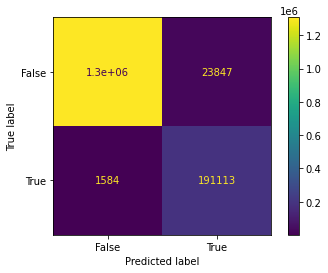

In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib
from sklearn import preprocessing

%cd /content/drive/MyDrive/FYP/Implementation/models
# Load the model from the file
logr = joblib.load('par_online.pkl')

#getting probabilities of class 1
prob= logr.predict(x)
normalizedData = (prob-np.min(prob))/(np.max(prob)-np.min(prob))

optimal_threshold = 0
maximum_f1 = 0

for i in range(1,100):
  threshold = i/100
  y_predict_class_train = [1 if p > threshold else 0 for p in normalizedData]
  f1 = f1_score(y, y_predict_class_train)
  if maximum_f1 < f1:
    maximum_f1 = f1
    optimal_threshold = threshold
    opt_y_train = y_predict_class_train 

accuracy = accuracy_score(y, opt_y_train)
print(f"maximum_train_f1_score: {maximum_f1}, accuracy: {accuracy}, optimal_threshold: {optimal_threshold: .6f}")
confusion_matrix = metrics.confusion_matrix(y, opt_y_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# **Test Set Results**

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/models
maximum_test_f1_score: 0.5471563859363423, accuracy: 0.8784797817348614, optimal_threshold:  0.510000


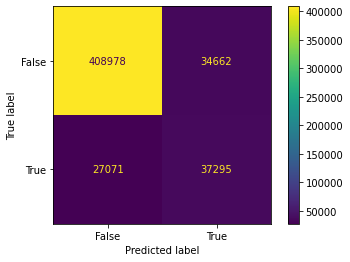

In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib


%cd /content/drive/MyDrive/FYP/Implementation/data
test_high_level_features=pd.read_csv("test_high_level_features.csv", sep=',', on_bad_lines='skip', index_col=False)


test_high_level_features.dropna()

#delete raws with missing values
for i in test_high_level_features.columns.values.tolist():
  i = test_high_level_features.loc[test_high_level_features[i].isnull()].index
  test_high_level_features = test_high_level_features.drop(index=list(i))
  
x_test= np.array(test_high_level_features.drop(labels=['Label'], axis=1))
y_test = np.array(test_high_level_features['Label'])

%cd /content/drive/MyDrive/FYP/Implementation/models
# Load the model from the file
logr = joblib.load('par_online.pkl')

#getting probabilities of class 1
prob = logr.predict(x_test)
prob = (prob-np.min(prob))/(np.max(prob)-np.min(prob))

optimal_threshold = 0
maximum_f1 = 0

for i in range(1,100):
  threshold = i/100
  y_predict_class_train = [1 if p > threshold else 0 for p in prob]
  f1 = f1_score(y_test, y_predict_class_train)
  if maximum_f1 < f1:
    maximum_f1 = f1
    optimal_threshold = threshold
    opt_y_train = y_predict_class_train

accuracy = accuracy_score(y_test, opt_y_train)
print(f"maximum_test_f1_score: {maximum_f1}, accuracy: {accuracy}, optimal_threshold: {optimal_threshold: .6f}")
confusion_matrix = metrics.confusion_matrix(y_test, opt_y_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
!pip uninstall numpy
!pip install numpy==1.23.4
!pip install river

Found existing installation: numpy 1.21.6
Uninstalling numpy-1.21.6:
  Would remove:
    /usr/bin/f2py
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.8
    /usr/local/lib/python3.8/dist-packages/numpy-1.21.6.dist-info/*
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libopenblasp-r0-2d23e62b.3.17.so
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.8/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.21.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>

In [ ]:
from river import linear_model
import pandas as pd
from river import compose
from river import metrics
from river import preprocessing
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib
from sklearn.utils import shuffle

from river import linear_model
from river import metrics
from river import stream
import numpy as np
from sklearn import datasets


%cd /content/drive/MyDrive/FYP/Implementation/data
high_level_features=pd.read_csv("high_level_features.csv", sep=',', on_bad_lines='skip', index_col=False)
test_high_level_features=pd.read_csv("test_high_level_features.csv", sep=',', on_bad_lines='skip', index_col=False)
OTset_high_level_features=pd.read_csv("OTset_high_level_features.csv", sep=',', on_bad_lines='skip', index_col=False)

all_data = pd.concat([high_level_features, test_high_level_features, OTset_high_level_features], axis=0)
all_data.dropna()

#delete raws with missing values
for i in all_data.columns.values.tolist():
  i = all_data.loc[all_data[i].isnull()].index
  all_data = all_data.drop(index=list(i))

print(type(all_data))
all_data = shuffle(all_data)
all_data.reset_index(inplace=True, drop=True)

x = np.array(all_data.drop(labels=['Label'], axis=1))
y =  np.array(all_data['Label'])
print(x.shape,y.shape)

model = (
    preprocessing.StandardScaler() |
   linear_model.ALMAClassifier()
 )


metric_accuracy = metrics.Accuracy()
metric_F1 = metrics.F1()
# metric = metrics.MAE() + metrics.MSE()
cm = metrics.ConfusionMatrix()

stats_f1 = list()
stats_accuracy = list()

for index, row in all_data.iterrows():
    x_current = row[:-1]
    y_current = row[-1]

    y_pred = model.predict_one(x_current)      # make a prediction
    # y_pred_array.append(y_pred)
    metric_accuracy = metric_accuracy.update(y_current, y_pred)  # update the metric
    metric_F1 = metric_F1.update(y_current, y_pred)  # update the metric
    stats_f1.append(metric_F1.get())
    stats_accuracy.append(metric_accuracy.get())
    model = model.learn_one(x_current, y_current)      # make the model learn
   
    # print(metric_accuracy)
    # print(metric_F1)

# confusion_matrix = confusion_matrix(all_data.iloc[:,-1],  y_pred_array)
# cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.plot()
# plt.show() 



%cd /content/drive/MyDrive/FYP/Implementation/data
stat_df=pd.read_csv('OT_Results.csv', sep=',', on_bad_lines='skip', index_col=False)
stat_df['PAR_F1_score'] = stats_f1
stat_df['PAR_Accuracy'] = stats_accuracy
stat_df.to_csv("OT_Results.csv", header=True, index=False)

# print(stats_f1)
# print(stats_accuracy)

# Save the model as a pickle in a file
%cd /content/drive/MyDrive/FYP/Implementation/models
joblib.dump(model, 'PAR_online_1.pkl')


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

%cd /content/drive/MyDrive/FYP/Implementation/data
OT_Results=pd.read_csv("OT_Results.csv", sep=',', on_bad_lines='skip', index_col=False)
OT_Results


/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data


,LR_F1_score,LR_Accuracy,PAR_F1_score,PAR_Accuracy
0,0.000000,1.000000,0.000000,1.000000
1,0.000000,0.500000,0.000000,1.000000
2,0.000000,0.333333,0.000000,0.666667
3,0.000000,0.500000,0.000000,0.500000
4,0.000000,0.600000,0.000000,0.600000
...,...,...,...,...
2540018,0.818749,0.953842,0.543669,0.838759
2540019,0.818749,0.953842,0.543669,0.838759
2540020,0.818749,0.953842,0.543669,0.838759
2540021,0.818749,0.953842,0.543669,0.838759


/content/drive/MyDrive/FYP/Implementation/data


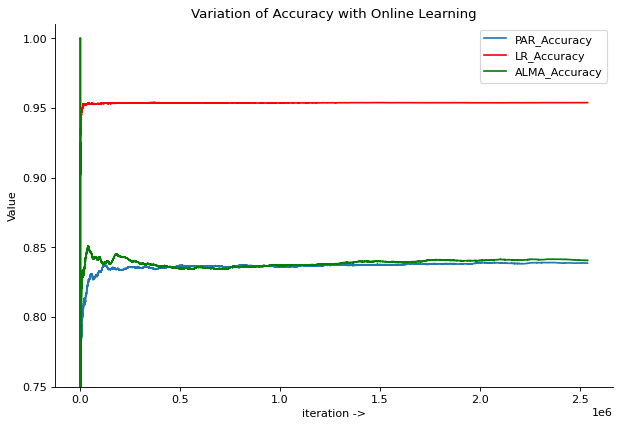

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd



figure(figsize=(9, 6), dpi=80)

%cd /content/drive/MyDrive/FYP/Implementation/data
OT_Results=pd.read_csv("OT_Results.csv", sep=',', on_bad_lines='skip', index_col=False)
OT_Results
plt.plot(OT_Results['PAR_Accuracy'].values)
plt.plot(OT_Results['LR_Accuracy'].values, "-r")
plt.plot(OT_Results['ALMA_Accuracy'].values, "-g")
# naming the x-axis
plt.xlabel('iteration ->')

# naming the y-axis
plt.ylabel('Value')

# set the interval by  which 
# the x-axis set the marks
# plt.xticks(list(range(500000, 2540022,500000)))

# set the intervals by which y-axis
# set the marks
plt.yticks(np.arange(0.75,1.02,0.05))

# get current axes command
ax = plt.gca()

# get command over the individual
# boundary line of the graph body
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.set_xlim([500000, 2540022])
ax.set_ylim([0.75, 1.01])

# legend denotes that what color 
# signifies what
# ax.legend(['PAR_Accuracy', 'LR_Accuracy','ALMA_Accuracy'])

# gives a title to the Graph
plt.title('Variation of Accuracy with Online Learning')
plt.legend(['PAR_Accuracy', 'LR_Accuracy','ALMA_Accuracy'], loc='upper right')

plt.show()

/content/drive/MyDrive/FYP/Implementation/data


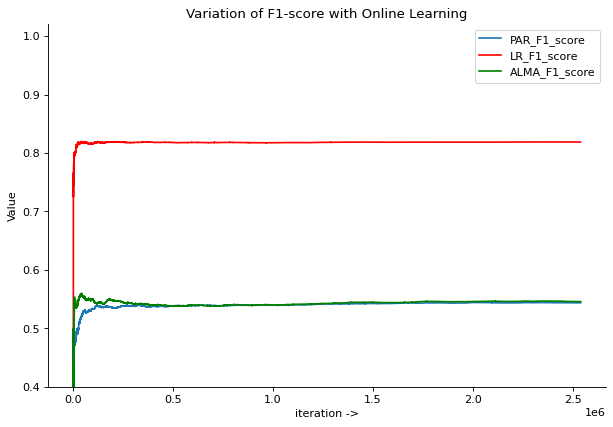

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd



figure(figsize=(9, 6), dpi=80)

%cd /content/drive/MyDrive/FYP/Implementation/data
OT_Results=pd.read_csv("OT_Results.csv", sep=',', on_bad_lines='skip', index_col=False)
OT_Results
plt.plot(OT_Results['PAR_F1_score'].values)
plt.plot(OT_Results['LR_F1_score'].values, "-r")
plt.plot(OT_Results['ALMA_F1_score'].values, "-g")

# naming the x-axis
plt.xlabel('iteration ->')

# naming the y-axis
plt.ylabel('Value')

# set the interval by  which 
# the x-axis set the marks
# plt.xticks(list(range(500000, 2540022,500000)))

# set the intervals by which y-axis
# set the marks
plt.yticks(np.arange(0.4,1.02,0.1))

# get current axes command
ax = plt.gca()

# get command over the individual
# boundary line of the graph body
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.set_xlim([500000, 2540022])
ax.set_ylim([0.4, 1.02])

# legend denotes that what color 
# signifies what
ax.legend(['PAR_F1_score', 'LR_F1_score','ALMA_F1_score'])

# gives a title to the Graph
plt.title('Variation of F1-score with Online Learning')


plt.show()